## Homework

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.


## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-04 03:34:38--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.008s  

2022-10-04 03:34:38 (9.02 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils.validation import check_is_fitted

from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('AER_credit_card_data.csv')

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 


## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [4]:
numeric = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
categorical = ['owner', 'selfemp']
target = 'card'

In [5]:
df.loc[df[target] == 'yes', target] = 1
df.loc[df[target] != 1, target] = 0
df = df.astype({target: 'uint8'})

In [6]:
def train_val_test_split(df, val_split=0.2, test_split=0.2, seed=None):

  # train_split = 1 - val_split - test_split

  # create splits
  df_full_train, df_test = train_test_split(df, test_size=test_split, random_state=seed)
  df_train, df_val = train_test_split(df_full_train, test_size=val_split/(1-test_split), random_state=seed)

  # return
  return (df_train, df_val, df_full_train, df_test)

In [7]:
def prepare(dv, df, features, target):

  feat_dict = df[features].to_dict(orient='records')
  
  try:
    check_is_fitted(dv, attributes='feature_names_')
  except NotFittedError as e:
    dv.fit(feat_dict)
  
  X = dv.transform(feat_dict)
  y = df[target].values

  return (X, y)

In [9]:
df_train, df_val, df_full_train, df_test = train_val_test_split(df, seed=1)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [10]:
variables = ['reports', 'dependents', 'active', 'share']

for var in variables:
  auc = roc_auc_score(df_train[target], df_train[var])
  print(var, abs(auc - 0.5) + 0.5)


reports 0.7166629860689376
dependents 0.5327757227773791
active 0.6043173411362006
share 0.989183643423692


# Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [11]:
dv = DictVectorizer(sparse=False)

X_train, y_train = prepare(dv, df_train, numeric+categorical, target)
X_val, y_val = prepare(dv, df_val, numeric+categorical, target)

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
above_average_pred = (y_pred >= 0.5)

# Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)


In [12]:
score = roc_auc_score(y_val, y_pred)
round(score, 3)

0.995

# Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

In [20]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns).set_index('threshold')

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['f1'] = (2 * df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)

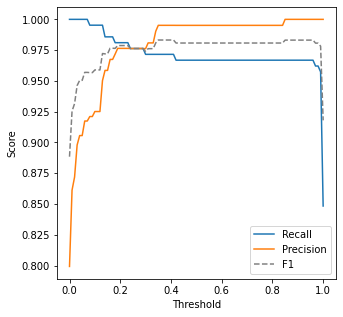

In [23]:
plt.figure(figsize=(5, 5))
plt.plot(df_scores.index, df_scores['recall'], label='Recall')
plt.plot(df_scores.index, df_scores['precision'], label='Precision')
plt.plot(df_scores.index, df_scores['f1'], label='F1', color='gray', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [15]:
df_scores['intersection'] = abs(df_scores.recall - df_scores.precision)
df_scores[df_scores.intersection == df_scores.intersection.min()]['intersection']

threshold
0.24    0.0
0.25    0.0
0.26    0.0
0.27    0.0
0.28    0.0
0.29    0.0
Name: intersection, dtype: float64

#  Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

In [16]:
df_scores['f1'] = (2 * df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)

In [19]:
df_scores[df_scores.f1 == df_scores.f1.max()]['f1']

threshold
0.35    0.983213
0.36    0.983213
0.37    0.983213
0.38    0.983213
0.39    0.983213
0.40    0.983213
0.41    0.983213
Name: f1, dtype: float64

# Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

In [26]:
df_full_train.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
710,0,1,36.83333,3.0000,0.000400,0.000000,yes,no,1,12,1,16
1258,1,0,35.58333,3.5606,0.109084,323.587500,no,no,0,12,1,0
435,1,0,25.66667,2.0000,0.004900,7.416667,no,no,0,26,1,13
987,0,0,25.58333,1.7500,0.000686,0.000000,no,no,0,108,0,0
1286,1,1,48.66667,6.0000,0.177017,885.085800,yes,no,3,114,1,19


In [37]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):

    dv = DictVectorizer(sparse=False)

    X_train, y_train = prepare(dv, df_full_train.iloc[train_idx], numeric+categorical, target)
    X_val, y_val = prepare(dv, df_full_train.iloc[val_idx], numeric+categorical, target)

    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=1)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    above_average_pred = (y_pred >= 0.5)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

0.996 +- 0.003


# Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [35]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):

        dv = DictVectorizer(sparse=False)

        X_train, y_train = prepare(dv, df_full_train.iloc[train_idx], numeric+categorical, target)
        X_val, y_val = prepare(dv, df_full_train.iloc[val_idx], numeric+categorical, target)

        model = LogisticRegression(solver="liblinear", C=C, max_iter=1000, random_state=1)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        above_average_pred = (y_pred >= 0.5)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003
